In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab07.ipynb")

# Lab 07: OLS
## Due Sunday, July 14, 11:59 PM PT

In this lab, you will review the details of linear regression. In particular:

* How to formulate Matrices and solutions to Ordinary Least Squares (OLS).
* `sns.lmplot` as a quick visual for Simple Linear Regression (SLR).
* `scikit-learn`, or `sklearn` for short, a real-world data science tool that is more robust and flexible than analytical or `scipy.optimize` solutions. 

You will also practice interpreting residual plots (vs. fitted values) and the Multiple $R^2$ metric used in Multiple Linear Regression.

To receive credit for a lab, answer all questions correctly and submit before the deadline.

**The on-time deadline is Sunday, July 14, 11:59 PM PT**. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to late-night requests for assistance (TAs need to sleep, after all!). **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to contact staff for submission support.

**This lab contains five written questions**, which will be graded based on completion and coherence. After submitting this assignment to the Lab 07 Coding assignment on Gradescope, Gradescope will automatically submit the PDF from this file to the Lab 07 Written assignment.


### Collaboration Policy

Data science is a collaborative activity. While you may talk to others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others, please **include their names** in the following cell:

**Collaborators**: *list names here*

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note:** This video is recorded in Spring 2022. There may be slight inconsistencies between the version you are viewing and the version used in the recording, but content is identical. Particularly, Question 4 is slightly different.

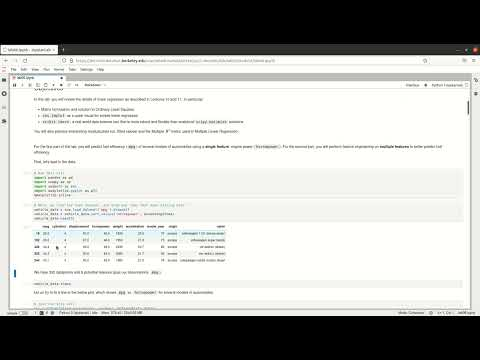

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("IkkhAr3e19Q", list = 'PLQCcNQgUcDfpuwnASdUyvQky51ZcYMWSy', listType = 'playlist')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

---
### Debugging Guide

If you run into any technical issues, we highly recommend checking out the [Data 100 Debugging Guide](https://ds100.org/debugging-guide/). In this guide, you can find general questions about Jupyter notebooks / Datahub, Gradescope, and common `pandas` and RegEx errors.

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Data Loading

For the first part of this lab, you will predict fuel efficiency (`mpg`) of several models of automobiles using a **single feature**: engine power (`horsepower`). For the second part, you will perform feature engineering on **multiple features** to better predict fuel efficiency.

First, let's load in the data.

In [4]:
# Here, we load the fuel dataset, and drop any rows that have missing data.
vehicle_data = sns.load_dataset('mpg').dropna()
vehicle_data = vehicle_data.sort_values('horsepower', ascending=True)
vehicle_data.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel)
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel)
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel


In [5]:
vehicle_data.shape

(392, 9)

We have 392 datapoints and 8 potential features (plus our observed $y$ values, `mpg`).

Let's try to fit a line to the plot below, which shows `mpg` vs. `horsepower` for several models of automobiles.

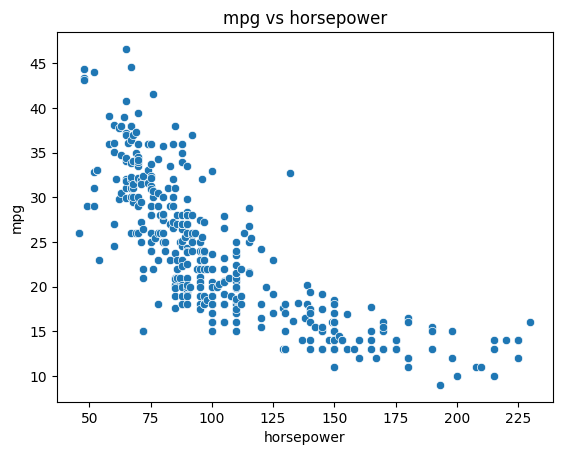

In [6]:
# Run this cell to visualize the data. 
sns.scatterplot(data=vehicle_data, x='horsepower', y='mpg');
plt.title("mpg vs horsepower");

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 1: Ordinary Least Squares
Recall that the equation for Simple Linear Regression (SLR) has two $\theta$ coefficients: $\theta_0$ and $\theta_1$, and is written as follows:

$$\hat{y} = \theta_0 + \theta_1 x$$


If we have many pairs of $(x_i, y_i)$ values, $(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)$, we would need to apply the SLR equation to each pair $n$ times. This is quite repetitive, so let's re-formulate our SLR equation using linear algebra. We'll:

* Rewrite our $\theta$ coefficients as a vector $\theta = [\theta_0, \theta_1]$.
* Stack our $x_i$ values into a vector $\vec{x}$ with $n$ values.
* Stack our $y_i$ values into a vector $\mathbb{Y}$ of all $n$ observations in our sample.

Then our prediction vector $\hat{\mathbb{Y}}$ can then be written as:
$$\Large \hat{\mathbb{Y}} = {\theta_0} \vec{1}_n + {\theta_1} \vec{x} = \begin{bmatrix} | & | \\ \vec{1}_n & \vec{x} \\ | & | \end{bmatrix} \begin{bmatrix} {\theta_0} \\ {\theta_1} \end{bmatrix} = \begin{bmatrix} 1 & x_1 \\ 1 & x_2 \\ \vdots & \vdots \\ 1 & x_n \end{bmatrix} \begin{bmatrix} {\theta_0} \\ {\theta_1} \end{bmatrix} = \Bbb{X} \begin{bmatrix} {\theta_0} \\ {\theta_1} \end{bmatrix} = \mathbb{X} \theta$$

where $\mathbb{X} \in \mathbb{R}^{n\times2}$ is the **design matrix** with a **bias** column of all ones to account for the intercept, $\theta_0$, and one **feature** for all $n$ datapoints in our sample. 

Our equation now matches the Ordinary Least Squares (OLS) equation! 
$$\Large \hat{\mathbb{Y}} = \mathbb{X} \theta$$


### Expanding OLS to Multiple Linear Regression
The OLS equation can be expanded to cases when we have more than one feature, like in the case of our Multiple Linear Regression (MLR) model, where we can have $p$ features: 
$$\hat{y} = \theta_0 + \theta_1 x_1 + \dots + \theta_p x_p$$

Our OLS equation can be generalized as  
$$\Large \hat{\mathbb{Y}} = \begin{bmatrix} 
    1  & x_{1,1}  & x_{1,2}  & \cdots & x_{1,p}\\
    1  & x_{2,1}  & x_{2,2}    & \cdots & x_{2,p}\\
    \vdots & \vdots & \vdots & \ddots & \vdots\\
    1  & x_{n,1}  & x_{n,2}    & \cdots & x_{n,p}
\end{bmatrix}  
\begin{bmatrix} {\theta_0} \\ {\theta_1} \\ \vdots \\ \theta_{p} \end{bmatrix} = \mathbb{X} \theta
$$
with a
* **prediction vector** $\mathbb{Y} \in \mathbb{R}^{n}$,
* **design matrix** $\mathbb{X} \in \mathbb{R}^{n\times(p + 1)}$ representing the $p$ features for all $n$ datapoints in our sample,
* and a **parameter vector** $\theta \in \mathbb{R}^{p + 1}$.

Simple linear regression is a special case of OLS when $p=1$.

### Today's Lab

In today's lab, we'll explore the OLS equations with different examples.
* In Question 1, we'll write code to evaluate linear algebra and apply those functions to predict `mpg` from one feature, `horsepower`. Since we only have one feature ($p=1$), this is a case of simple linear regression.
* In Question 2, we'll explore how transforming data affects our prediction by using horsepower squared (`hp^2`) as our feature instead of `horsepower`. 
* In Question 3, we'll combine the features from questions 1 and 2 and use *multiple linear regression* on 2 features: `horsepower` and `hp^2`.
* Finally for question 4, we'll explore how redundant features affect our calculations.

<br>

---

### Question 1a: Construct $\mathbb{X}$ with an intercept term
The OLS equation is displayed for your reference: 
$$\Large \hat{\mathbb{Y}} = \mathbb{X} \theta$$

Because we have an intercept term $\theta_0$ in our parameter vector $\theta$, our design matrix $\mathbb{X}$ needs a column with all-ones such that the resulting matrix expression, $\hat{\mathbb{Y}} = \mathbb{X} \theta$, represents $n$ linear equations, where equation $i$ is 
$$\hat{y_i} = \theta_0 \cdot 1 + \theta_1 \cdot x_{i, 1} + \dots + \theta_p \cdot x_{i, p}$$ 
where $x_{i, j}$ is the $j^{th}$ feature of the $i^{th}$ datapoint. The constant all-ones column of $\mathbb{X}$ is sometimes called the bias feature; $\theta_0$ is frequently called the **bias or intercept term**. 

> _Note:_ <span style="color:gray">
At other points in the course, and by convention, we may represent the model using an equivalent expression written without the index $i$, namely:
$$\hat{y} = \theta_0 + \theta_1 x_{1} + \dots + \theta_p x_{p}$$
> When written out like this, the symbols $x_{i, j}$ and $x_{j}$ are functionally identical - both refer to the $j^{th}$ feature of the $i^{th}$ datapoint. The $i$ is implicit in the case of the latter, but we are still talking in terms of numerical values, not vectors.
</span>


In order to construct the design matrix $\mathbb{X} \in \mathbb{R}^{n\times(p + 1)}$ from a given `DataFrame`, `X`, with a dimension of $n$ rows by $p$ columns, we need to augment our `DataFrame` with a column of ones.



<br/>

Below, implement `add_intercept`, which creates a design matrix such that the first (left-most) column is all ones. The function has two lines: you are responsible for constructing the all-ones column `bias_feature` using the `np.ones` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.ones.html?highlight=ones)). This is then piped into a call to `np.concatenate` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)), which we've implemented for you.

**Note:** `bias_feature` should be a matrix of dimension `(n,1)`, not a vector of dimension `(n,)`.


In [9]:
def add_intercept(X):
    """
    Return X with a bias feature.
    
    Parameters
    -----------
    X: a 2D DataFrame of p numeric features
    (may also be a 2D NumPy array) of shape n x p
    
    Returns
    -----------
    A 2D matrix of shape n x (p + 1), where the leftmost
    column is a column vector of 1's.
    """
    n = X.shape[0]
    bias_feature = np.ones((n, 1))
    return np.concatenate([bias_feature, X], axis=1)

# Note the [[ ]] brackets below: the argument needs to be
# a matrix (DataFrame), as opposed to a single array (Series).
X = add_intercept(vehicle_data[['horsepower']])
X.shape

(392, 2)

In [10]:
grader.check("q1a")

q1a results: All test cases passed!

<br>

---
### Question 1b: Define the OLS Model

The predictions for all $n$ points in our data are:
$$ \Large \hat{\mathbb{Y}} = \mathbb{X}\theta $$
where $\theta = [\theta_0, \theta_1, \dots, \theta_p]$.

Below, implement the `linear_model` function to evaluate this product.

**Hint**: You can use `np.dot` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.dot.html)), `pd.DataFrame.dot` ([documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dot.html)), or the `@` operator to multiply matrices/vectors. However, while the `@` operator can be used to multiply `NumPy` arrays, it generally will not work between two `pandas` objects, so keep that in mind when computing matrix-vector products!

In [19]:
def linear_model(thetas, X):
    """
    Return the linear combination of thetas and features as defined in the OLS equation.
    
    Parameters
    -----------
    thetas: a 1D vector representing the parameters of our model ([theta0, theta1, ...]).
    X: a 2D DataFrame of numeric features (may also be a 2D NumPy array).
    
    Returns
    -----------
    A 1D vector representing the linear combination of thetas and features as defined in the OLS equation.
    """
    return np.dot(X, thetas)

In [20]:
grader.check("q1b")

q1b results: All test cases passed!

<br>

---

### Question 1c: Least Squares Estimate, Analytically

Recall from lecture that Ordinary Least Squares is when we fit a linear model using Mean Squared Error (MSE), which is equivalent to the following optimization problem:

$$\Large \min_{\theta} ||\Bbb{X}\theta - \Bbb{Y}||^2$$

We showed in lecture that when $X^TX$ is invertible, the optimal estimate, $\hat{\theta}$, is given by the equation:

$$ \Large \hat{\theta} = (\Bbb{X}^T\Bbb{X})^{-1}\Bbb{X}^T\Bbb{Y}$$

Below, implement the analytic solution to $\hat{\theta}$ using `np.linalg.inv` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.inv.html)) to compute the inverse of $\Bbb{X}^T\Bbb{X}$.

**Hint 1**: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.T.html#numpy.ndarray.T)).

**Note:** You can also consider using `np.linalg.solve` ([documentation](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html)) instead of `np.linalg.inv` because it is more robust (more on StackOverflow [here](https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li)). 


In [21]:
def get_analytical_sol(X, y):
    """
    Computes the analytical solution to our
    least squares problem
    
    Parameters
    -----------
    X: a 2D DataFrame (or NumPy array) of numeric features.
    y: a 1D vector of outputs.
    
    Returns
    -----------
    The estimate for theta (a 1D vector) computed using the
    equation mentioned above.
    """
    return np.linalg.inv(X.T @ X) @ X.T @ y

Y = vehicle_data['mpg']
analytical_thetas = get_analytical_sol(X, Y)
analytical_thetas

array([39.93586102, -0.15784473])

In [22]:
grader.check("q1c")

q1c results: All test cases passed!

<br/>

Now, let's analyze our model's performance. Your task will be to interpret the model's performance using the two visualizations and one performance metric we've implemented below.

First, we run `sns.lmplot`, which will both provide a scatterplot of `mpg` vs `horsepower` and display the least-squares line of best fit. (If you'd like to verify the OLS fit you found above is the same line found through `Seaborn`, change `include_OLS` to `True`.)

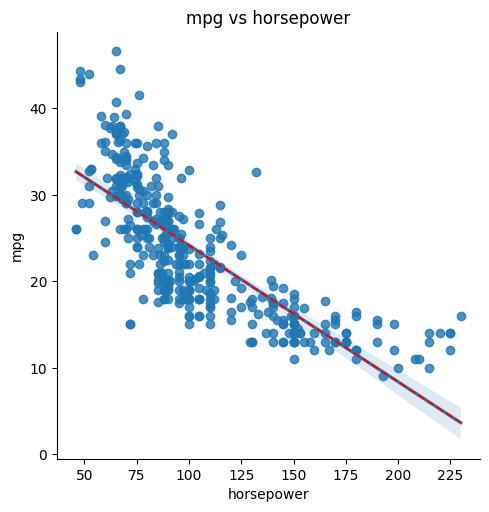

In [26]:
include_OLS = True # Change this flag to visualize OLS fit

sns.lmplot(data=vehicle_data, x='horsepower', y='mpg');
predicted_mpg_hp_only = linear_model(analytical_thetas, X)
if include_OLS:
    # if flag is on, add OLS fit as a dotted red line
    plt.plot(vehicle_data['horsepower'], predicted_mpg_hp_only, 'r--')
plt.title("mpg vs horsepower");

Next, we **plot the residuals.** While in Simple Linear Regression we have the option to plot residuals vs. the single input feature, in Multiple Linear Regression we often plot residuals vs. fitted values $\hat{\mathbb{Y}}$. In this lab, we opt for the latter.

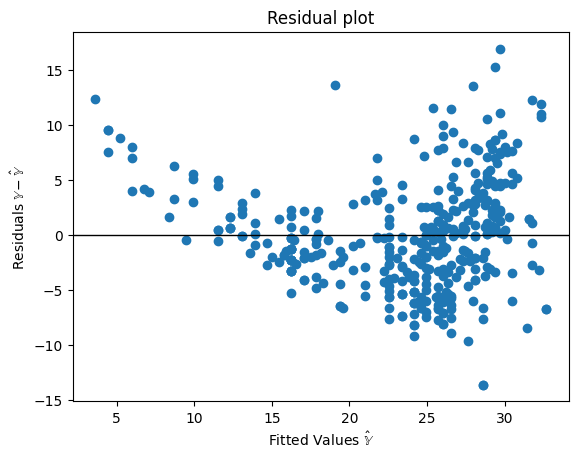

In [27]:
plt.scatter(predicted_mpg_hp_only, Y - predicted_mpg_hp_only)
plt.axhline(0, c='black', linewidth=1)
plt.xlabel(r'Fitted Values $\hat{\mathbb{Y}}$')
plt.ylabel(r'Residuals $\mathbb{Y} - \hat{\mathbb{Y}}$');
plt.title("Residual plot");

Finally, we compute the **correlation r** and **Multiple $R^2$** metric. As described in Lecture 12,

$$R^2 = \frac{\text{variance of fitted values}}{\text{variance of true } y} = \frac{\sigma_{\hat{y}}^2}{\sigma_y^2}$$

$R^2$  can be used
in the multiple regression setting, whereas $r$ (the correlation coefficient) is restricted to SLR since it depends on a single input feature.  In SLR, $r^{2}$ and Multiple $R^{2}$ are
equivalent; the proof is left to you.

In [28]:
r_hp_only = np.corrcoef(X[:, 1], Y)[0, 1]
r2_hp_only = r_hp_only ** 2
R2_hp_only = np.var(predicted_mpg_hp_only) / np.var(Y)

print('Correlation, r, using only horsepower: ', r_hp_only)
print('Correlation squared, r^2, using only horsepower: ', r2_hp_only)
print('Multiple R^2 using only horsepower: ', r2_hp_only)

Correlation, r, using only horsepower:  -0.7784267838977761
Correlation squared, r^2, using only horsepower:  0.605948257889435
Multiple R^2 using only horsepower:  0.605948257889435


<!-- BEGIN QUESTION -->

<br>

---
### Question 1d

In the cell below, comment on the above visualization and performance metrics, and whether `horsepower` and `mpg` have a good linear fit.


Just so-so.

<!-- END QUESTION -->

<br/>
<hr style="border: 1px solid #fdb515;" />

## Question 2: Transform a Single Feature

The Tukey-Mosteller Bulge Diagram (shown below) tells us to transform our $\mathbb{X}$ or $\mathbb{Y}$ to find a linear fit.

<div style="text-align:center"><img src="tukey_mosteller.png" width="300vw" /></div>

Let's consider the following linear model:

$$\text{predicted mpg} = \theta_0 + \theta_1 \sqrt{\text{horsepower}}$$

<!-- BEGIN QUESTION -->

<br>

---
### Question 2a

In the cell below, explain why we use the term "linear" to describe the model above, even though it incorporates a square root of horsepower  as a feature.


Square root of horsepower have been considered as an independent variavle in the linear model.

<!-- END QUESTION -->

### Introduction to `sklearn`

Another way to fit a linear regression model is to use `scikit-learn`, an industry-standard package for machine learning applications. Because it is application-specific, `sklearn` is often faster and more robust than the analytical or `scipy`-based computation methods we've used thus far. Note that `scikit-learn` and `sklearn` refers to the same package, but it can only be imported under the name `sklearn`. We will use these two names interchangeably in this class.

To use `sklearn`:

1. Create an `sklearn` object.
1. `fit` the object to data.
1. Analyze fit or call `predict`.

##### **1. Create object.** 

We first create a `LinearRegression` object. Here's the `sklearn` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). Note that by default, the object will include an intercept term when fitting.

Here, `model` is like a "blank slate" for a linear model.

In [29]:
# 1. Run this cell to initialize a sklearn LinearRegression object.
from sklearn.linear_model import LinearRegression

# the `fit_intercept` argument controls whether or not the model should have an intercept (or bias) term
model = LinearRegression(fit_intercept=True)
model

LinearRegression()

##### **2. `fit` the object to data.** 

Now, we need to tell `model` to "fit" itself to the data. Essentially, this is doing exactly what you did in the previous part of this lab (creating a risk function and finding the parameters that minimize that risk).

**Note**: `X` needs to be a matrix (or `DataFrame`), as opposed to a single array (or `Series`) when running `model.fit`. This is because `sklearn.linear_model` is robust enough to be used for multiple regression, which we will look at later in this lab. This is why we use the double square brackets around `sqrt(hp)` when passing in the argument for `X`.

In [30]:
# 2. Run this cell to add sqrt(hp) column for each car in the dataset.
vehicle_data['sqrt(hp)'] = np.sqrt(vehicle_data['horsepower'])
vehicle_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,sqrt(hp)
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan,6.782330
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle,6.782330
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel),6.928203
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel),6.928203
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel,6.928203


In [31]:
# 2. Run this cell to fit the model to the data.
model.fit(X = vehicle_data[['sqrt(hp)']], y = vehicle_data['mpg'])

LinearRegression()

##### **3. Analyze fit.** 

Now that the model exists, we can look at the $\hat{\theta}_0$ and $\hat{\theta}_1$ values it found, which are given in the attributes `intercept` and `coef`, respectively.

In [32]:
model.intercept_

58.705172037217466

In [33]:
model.coef_

array([-3.50352375])

To use the `sklearn` linear regression model to make predictions, you can use the `model.predict` method.

Below, we find the estimated `mpg` for a single datapoint with a `sqrt(hp)` of 6.78 (i.e., horsepower 46). Unlike the linear algebra approach, we do not need to manually add an intercept term because our `model` (which was created with `fit_intercept=True`) will automatically add one.

**Note:** You may receive a user warning about missing feature names. This is due to the fact that we fitted on the feature DataFrame `vehicle_data[['sqrt(hp)']]` with feature names `"sqrt(hp)"` but only pass in a simple 2D arrays for prediction. To avoid this, we can convert our 2D array into a DataFrame with the matching feature name.

In [37]:
# Needs to be a 2D array since the X in step 2 was 2-dimensional.
# single_datapoint = [[6.78]]
# Uncomment the following to see the result of predicting on a DataFrame instead of 2D array.
single_datapoint = pd.DataFrame([[6.78]], columns = ['sqrt(hp)']) # 
model.predict(single_datapoint) 

array([34.95128104])

<!-- BEGIN QUESTION -->

<br>

---

### Question 2b

Using the model defined above, which takes in `sqrt(hp)` as an input explanatory variable, predict the `mpg` for the full `vehicle_data` dataset. Assign the predictions to `predicted_mpg_hp_sqrt`. Running the cell will then compute the multiple $R^2$ value and create a linear regression plot for this new square root feature, overlaid on the original least squares estimate (used in Question 1c).

Multiple R^2 using sqrt(hp):  0.6437035832706468


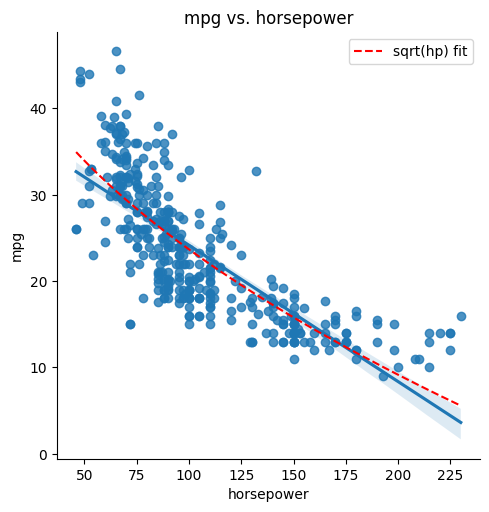

In [39]:
predicted_mpg_hp_sqrt = model.predict(vehicle_data[["sqrt(hp)"]])

# Do not modify below this line.
r2_hp_sqrt = np.var(predicted_mpg_hp_sqrt) / np.var(vehicle_data['mpg'])
print('Multiple R^2 using sqrt(hp): ', r2_hp_sqrt)

sns.lmplot(x = 'horsepower', y = 'mpg', data = vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_sqrt,
         color = 'r', linestyle='--', label='sqrt(hp) fit');
plt.title("mpg vs. horsepower")
plt.legend();

<!-- END QUESTION -->

The visualization shows a slight improvement, but the points on the scatter plot are still more "curved" than our prediction line. Let's try a quadratic feature instead! 

Next, we use the power of OLS to **add an additional feature.** Questions 1 and 2 utilized simple linear regression, a special case of OLS where we have 1 feature ($p=1$). For the following questions, we'll utilize multiple linear regression, which are cases of OLS when we have more than 1 features ($p > 1$). 

<br/>
<hr style="border: 1px solid #fdb515;" />

## Add an Additional Feature

For the second part of this lab, we move from SLR to multiple linear regression.

Until now, we have established relationships between one independent explanatory variable and one response variable. However, with real-world problems, you will often want to use **multiple features** to model and predict a response variable. Multiple linear regression attempts to model the relationship between two or more explanatory variables and a response variable by fitting a linear equation to the observed data.

We can consider including functions of existing features as **new features** to help improve the predictive power of our model. (This is something we will discuss in further detail in the Feature Engineering lecture.)

The cell below adds a column that contains the square of the horsepower for each car in the dataset.

In [40]:
# Run this cell to add a column of horsepower squared, no further action needed.
vehicle_data['hp^2'] = vehicle_data['horsepower'] ** 2
vehicle_data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,sqrt(hp),hp^2
19,26.0,4,97.0,46.0,1835,20.5,70,europe,volkswagen 1131 deluxe sedan,6.782330,2116.0
102,26.0,4,97.0,46.0,1950,21.0,73,europe,volkswagen super beetle,6.782330,2116.0
326,43.4,4,90.0,48.0,2335,23.7,80,europe,vw dasher (diesel),6.928203,2304.0
325,44.3,4,90.0,48.0,2085,21.7,80,europe,vw rabbit c (diesel),6.928203,2304.0
244,43.1,4,90.0,48.0,1985,21.5,78,europe,volkswagen rabbit custom diesel,6.928203,2304.0


<br>

---
## Question 3

### Question 3a

Using `sklearn`'s `LinearRegression`, create and fit a model that tries to predict `mpg` from `horsepower` AND `hp^2` using the DataFrame `vehicle_data`. Name your model `model_multi`.

**Hint**: It should follow a similar format as Question 2.

**Note**: You must create a new model again using `LinearRegression()`, otherwise the old model from Question 2 will be overwritten. If you do overwrite it, don't fret! Just restart your kernel and run your cells in order. If you are unsure why this overwritting happens, please review [object-oriented programming](https://cs61a.org/study-guide/objects/) from CS61A.

In [46]:
model_multi = LinearRegression() # By default, fit_intercept=True
model_multi.fit(X = vehicle_data[["horsepower", "hp^2"]], y = vehicle_data["mpg"])

LinearRegression()

In [47]:
grader.check("q3a")

q3a results: All test cases passed!

After fitting, we can see the coefficients and intercept. Note that there are now two elements in `model_multi.coef_`, since there are two features.

In [48]:
model_multi.intercept_

56.90009970211301

In [49]:
model_multi.coef_

array([-0.46618963,  0.00123054])

<!-- BEGIN QUESTION -->

<br>

---

### Question 3b

Using the above values, write out the function that the model is using to predict `mpg` from `horsepower` and `hp^2`.

**Note**: If you are using LaTeX, please keep the `^2` outside of any `\text` curly brackets! For example, use `\text{example}^2` instead of `\text{example^2}`. This will help us avoid PDF compilation errors!


\begin{align}
\text{mpg} &= \theta_0 + \theta_1 \cdot \text{horsepower} + \theta_2 \cdot \text{horsepower}^2
\end{align}

<!-- END QUESTION -->

<br/>

The plot below shows the prediction of our model. It's much better!

Multiple R^2 using both horsepower and horsepower squared:  0.6875590305127546


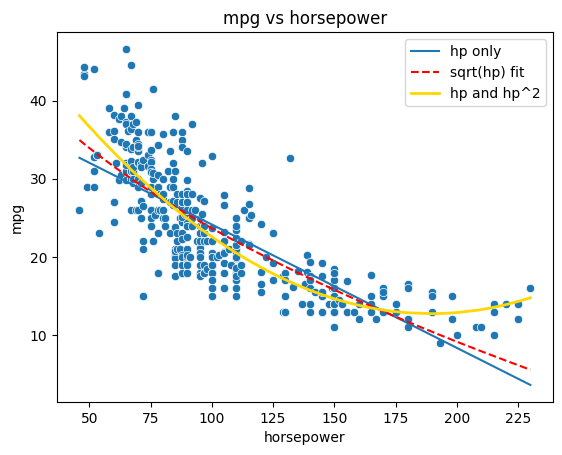

In [51]:
# Run this cell to show the prediction of our model.
predicted_mpg_multi = model_multi.predict(vehicle_data[['horsepower', 'hp^2']])
r2_multi = np.var(predicted_mpg_multi) / np.var(vehicle_data['mpg'])
print('Multiple R^2 using both horsepower and horsepower squared: ', r2_multi)

sns.scatterplot(x = 'horsepower', y = 'mpg', data = vehicle_data)
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_only, label='hp only');
plt.plot(vehicle_data['horsepower'],  predicted_mpg_hp_sqrt, color = 'r', linestyle='--', label='sqrt(hp) fit');
plt.plot(vehicle_data['horsepower'],  predicted_mpg_multi, color = 'gold', linewidth=2, label='hp and hp^2');
plt.title("mpg vs horsepower")
plt.legend();

By incorporating a squared feature, we are able to capture the curvature of the dataset. Our model is now a parabola centered on our data. 

<br>

---

### Question 3c

In the cell below, we assign the mean of the `mpg` column of the `vehicle_data` DataFrame to `mean_mpg`. Given this information, what is the mean of the `mean_predicted_mpg_hp_only`, `predicted_mpg_hp_sqrt`, and `predicted_mpg_multi` arrays?

**Hint**: Your answer should be a function of `mean_mpg` provided, you should not have to call `np.mean` in your code.


In [56]:
mean_mpg = np.mean(vehicle_data['mpg'])
mean_predicted_mpg_hp_only = mean_mpg
mean_predicted_mpg_hp_sqrt = mean_mpg
mean_predicted_mpg_multi = mean_mpg

In [57]:
grader.check("q3c")

q3c results: All test cases passed!

Comparing this model with previous models:

In [58]:
# Compares q1, q2, q3, and overfit models (ignores redundant model)
print('Multiple R^2 using only horsepower: ', r2_hp_only)
print('Multiple R^2 using sqrt(hp): ', r2_hp_sqrt)
print('Multiple R^2 using both hp and hp^2: ', r2_multi)

Multiple R^2 using only horsepower:  0.605948257889435
Multiple R^2 using sqrt(hp):  0.6437035832706468
Multiple R^2 using both hp and hp^2:  0.6875590305127546


Observe that the R^2 value of the last model is the highest. In fact, it can be proven that multiple R^2 will not decrease as we add more variables. You may be wondering, what will happen if we add more variables? We will discuss the limitations of adding too many variables in an upcoming lecture. Below, we consider an extreme case that we include a variable twice in the model.

You might also be wondering why we chose to use `hp^2` as our additional feature, even though that transformation in the Tukey-Mosteller Bulge Diagram doesn't correspond to the bulge in our data. The Bulge diagram is a good starting point for transforming our data, but you may need to play around with different transformations to see which of them is able to capture the true relationship in our data and create a model with the best fit. This trial and error process is a very useful technique used all throughout data science!

<br/>
<hr style="border: 1px solid #fdb515;" />

## Faulty Feature Engineering: Redundant Features

Suppose we used the following linear model:

\begin{align}
\text{mpg} &= \theta_0 + \theta_1 \cdot \text{horsepower} + \theta_2 \cdot \text{horsepower}^2 + \theta_3 \cdot \text{horsepower} + \theta_4 \cdot \text{horsepower}
\end{align}

Notice that `horsepower` appears three times in our model!! We will explore how this redundant feature affects our modeling.

<br>

---

## Question 4

### Question 4a: Linear Algebra

Construct a matrix `X_redundant` that uses the `vehicle_data` DataFrame to encode the "four" features above, as well as a bias feature.

**Hint**: Use the `add_intercept` term you implemented in Question 1a.


In [60]:
X_redundant = add_intercept(vehicle_data[["horsepower", "hp^2", "horsepower", "horsepower"]])
X_redundant.shape

(392, 5)

In [61]:
grader.check("q4a")

q4a results: All test cases passed!

<br>

Now, run the cell below to find the analytical OLS Estimate using the `get_analytical_sol` function you wrote in Question 1c.

**Note:** Depending on the machine that you run your code on, you should either **see a singular matrix error** or **end up with thetas that are nonsensical** (magnitudes greater than $10^{15}$). In other words, if the cell below errors, that is by design, it is supposed to error. 

In [62]:
# Run this cell to check the result, no further action needed. 
# The try-except block suppresses errors during submission
import traceback
try:
    analytical_thetas = get_analytical_sol(X_redundant, vehicle_data['mpg'])
    print(analytical_thetas)
except Exception as e:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_8956\3728455724.py", line 5, in <module>
    analytical_thetas = get_analytical_sol(X_redundant, vehicle_data['mpg'])
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_8956\2343644951.py", line 16, in get_analytical_sol
    return np.linalg.inv(X.T @ X) @ X.T @ y
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\numpy\linalg\linalg.py", line 561, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\numpy\linalg\linalg.py", line 112, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix



<!-- BEGIN QUESTION -->

---

### Question 4b

In the cell below, explain why we got the error above when trying to calculate the analytical solution to predict `mpg`.


The matrix X is ​​not invertible, because there is a linear correlation between the explanatory varibles.

<!-- END QUESTION -->

**Note 1**: While we encountered errors when using the linear algebra approach, a model fitted with `sklearn` will not encounter matrix singularity errors since it uses numerical methods to find optimums (to be covered in the Gradient Descent lecture).

In [63]:
# Run this cell to check the result, no further action needed. 
# sklearn finds optimal parameters despite redundant features
model_redundant = LinearRegression(fit_intercept=False) # X_redundant already has an intercept column
model_redundant.fit(X = X_redundant, y = vehicle_data['mpg'])
model_redundant.coef_

array([ 5.69000997e+01, -1.55396543e-01,  1.23053610e-03, -1.55396543e-01,
       -1.55396543e-01])

**Note 2**: In some situations, `np.linalg.inv` is actually able to approximately "invert" non-invertible matrices! In fact, if we had only added one redundant `horsepower` column, `get_analytical_sol` would have succeeded in estimating the OLS solution despite $X^TX$ being **non-invertible**. If you're interested in reading more, see [this Stack Overflow post](https://stackoverflow.com/questions/41841509/numpy-inverts-a-non-invertible-matrix).

Run the cell below to see what happens:

In [67]:
# Run this cell to check the result, no further action needed. 
X_less_redundant = add_intercept(vehicle_data[['horsepower', 'hp^2', 'horsepower']])
try:
    analytical_thetas = get_analytical_sol(X_less_redundant, vehicle_data['mpg'])
    print(analytical_thetas)
except Exception as e:
    print(traceback.format_exc())

Traceback (most recent call last):
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_8956\3868543868.py", line 4, in <module>
    analytical_thetas = get_analytical_sol(X_less_redundant, vehicle_data['mpg'])
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\AppData\Local\Temp\ipykernel_8956\2343644951.py", line 16, in get_analytical_sol
    return np.linalg.inv(X.T @ X) @ X.T @ y
           ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\numpy\linalg\linalg.py", line 561, in inv
    ainv = _umath_linalg.inv(a, signature=signature, extobj=extobj)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\lenovo\AppData\Roaming\Python\Python312\site-packages\numpy\linalg\linalg.py", line 112, in _raise_linalgerror_singular
    raise LinAlgError("Singular matrix")
numpy.linalg.LinAlgError: Singular matrix



However, if we actually check $(X^TX)^{-1}(X^TX)$, we can see that the resulting value is not the identity matrix. Remember that for any invertible matrix $A$, $A^{-1}A$ should be equivalent to the identity matrix. This corroborates that the matrix `np.linalg.inv` is outputting here is not the inverse, it's just an estimate.

In [69]:
# Run this cell to check the result, no further action needed. 
# np.linalg.inv(X_less_redundant.T @ X_less_redundant) @ (X_less_redundant.T @ X_less_redundant)

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# Snowy congratulates you for finishing Lab 07!

<img src='snowy.jpg' width="400px" />

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://forms.gle/owfPCGgnrju1xQEA9). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Submit this file to the Lab 07 Coding assignment on Gradescope. Gradescope will automatically submit the PDF from this file to the Lab 07 Written assignment. There is no need to manually submit Lab 07 Written answers; however, please check that the PDF was generated and submitted correctly. If you run into any issues when running this cell, feel free to check this section in the Data 100 Debugging Guide. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [70]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1a results: All test cases passed!

    q1b results: All test cases passed!

    q1c results: All test cases passed!

    q3a results: All test cases passed!

    q3c results: All test cases passed!

    q4a results: All test cases passed!
